In [1]:
import tensorflow as tf

# 1. Keras 모델 로드
model = tf.keras.models.load_model('v3l_adam_lr001.h5')
print("Keras 모델이 성공적으로 로드되었습니다.")

# 2. TFLite Converter 생성
converter = tf.lite.TFLiteConverter.from_keras_model(model)
print("TensorFlow Lite Converter가 생성되었습니다.")

# 3. 최적화 설정 (선택 사항)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 4. (선택 사항) Float16 양자화
# converter.target_spec.supported_types = [tf.float16]

# 5. 변환 수행
tflite_model = converter.convert()
print("모델이 TensorFlow Lite 형식으로 변환되었습니다.")

# 6. TFLite 모델 저장
tflite_model_path = 'v3l_adam_lr001.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"TensorFlow Lite 모델이 성공적으로 저장되었습니다: {tflite_model_path}")



2024-11-06 08:46:03.202976: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 08:46:03.260969: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 08:46:03.261015: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 08:46:03.261051: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 08:46:03.273116: I tensorflow/core/platform/cpu_feature_g

Keras 모델이 성공적으로 로드되었습니다.
TensorFlow Lite Converter가 생성되었습니다.
INFO:tensorflow:Assets written to: /tmp/tmpa3r_5cwk/assets


INFO:tensorflow:Assets written to: /tmp/tmpa3r_5cwk/assets
2024-11-06 08:46:35.334356: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-11-06 08:46:35.334401: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-11-06 08:46:35.335295: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpa3r_5cwk
2024-11-06 08:46:35.383058: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-11-06 08:46:35.383093: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpa3r_5cwk
2024-11-06 08:46:35.476278: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-11-06 08:46:35.514733: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-11-06 08:46:36.669979: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

모델이 TensorFlow Lite 형식으로 변환되었습니다.
TensorFlow Lite 모델이 성공적으로 저장되었습니다: v3l_adam_lr001.tflite


In [3]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def plot_predicted_keypoints_tflite(tflite_model_path, image_path, image_dir, target_size=224):
    """
    TFLite 모델을 사용하여 이미지의 키포인트를 예측하고 시각화하는 함수.

    Parameters:
        tflite_model_path (str): 변환된 TFLite 모델의 경로.
        image_path (str): 예측할 이미지의 경로.
        image_dir (str): 이미지가 저장된 디렉토리 경로.
        target_size (int): 모델의 입력 이미지 크기.
    """
    # 1. TFLite Interpreter 로드 및 초기화
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    print("TFLite Interpreter가 성공적으로 로드되고 초기화되었습니다.")

    # 2. 입력 및 출력 텐서 정보 가져오기
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # 입력 텐서의 데이터 타입 확인
    input_dtype = input_details[0]['dtype']
    print(f"모델 입력 데이터 타입: {input_dtype}")

    # 3. 이미지 로드 및 전처리
    image_full_path = os.path.join(image_dir, image_path)
    image = cv2.imread(image_full_path)
    if image is None:
        print(f"이미지를 불러올 수 없습니다: {image_full_path}")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    orig_h, orig_w = image_rgb.shape[:2]

    # 이미지 전처리 (학습 시 사용한 방식과 동일하게)
    # 종횡비 유지하며 리사이즈
    scale = min(target_size / orig_w, target_size / orig_h)
    new_w = int(orig_w * scale)
    new_h = int(orig_h * scale)
    image_resized = cv2.resize(image_rgb, (new_w, new_h))

    print(f"Original size: ({orig_w}, {orig_h})")
    print(f"Scale factor: {scale}")
    print(f"Resized size: ({new_w}, {new_h})")

    # 패딩 추가하여 타겟 사이즈 맞추기
    pad_w = target_size - new_w
    pad_h = target_size - new_h
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top

    print(f"Padding (left, top): ({pad_left}, {pad_top})")
    print(f"Padding (right, bottom): ({pad_right}, {pad_bottom})")

    image_padded = cv2.copyMakeBorder(
        image_resized, pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT, value=0
    )

    # 이미지 흑백 변환 및 3채널로 확장 (모델 학습 시에 흑백 이미지를 사용한 경우)
    image_gray = cv2.cvtColor(image_padded, cv2.COLOR_RGB2GRAY)
    image_input = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)

    # 정규화 및 배치 차원 추가
    input_image = image_input / 255.0
    input_image = np.expand_dims(input_image, axis=0).astype(np.float32)

    # TFLite 모델 입력 데이터 타입에 맞게 변환
    if input_dtype == np.float32:
        input_tensor = input_image.astype(np.float32)
    elif input_dtype == np.int8:
        # 양자화된 모델의 경우 입력을 int8로 변환
        # 예를 들어, (input - zero_point) / scale 을 적용해야 할 수 있습니다.
        # 여기서는 단순히 float32를 int8로 캐스팅하는 예시를 제공합니다.
        input_tensor = (input_image * 127).astype(np.int8)
    else:
        raise ValueError(f"지원되지 않는 입력 데이터 타입: {input_dtype}")

    # 4. 입력 텐서 설정
    interpreter.set_tensor(input_details[0]['index'], input_tensor)

    # 5. 모델 실행
    interpreter.invoke()

    # 6. 출력 텐서 가져오기
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # 출력 데이터 타입에 따라 처리
    if output_details[0]['dtype'] == np.float32:
        predicted_keypoints = output_data[0]
    elif output_details[0]['dtype'] == np.int8:
        # 양자화된 모델의 경우 출력을 float으로 변환
        # 예를 들어, (output - zero_point) * scale 을 적용해야 할 수 있습니다.
        # 여기서는 단순히 int8을 float으로 캐스팅하는 예시를 제공합니다.
        predicted_keypoints = output_data[0].astype(np.float32) / 127.0
    else:
        raise ValueError(f"지원되지 않는 출력 데이터 타입: {output_details[0]['dtype']}")

    # 모델 출력이 [0,1] 범위이므로, 이를 [0, target_size]로 변환
    predicted_keypoints = predicted_keypoints * target_size

    # 패딩 제거 및 원본 이미지 크기로 복원
    predicted_keypoints[::2] = (predicted_keypoints[::2] - pad_left) / scale
    predicted_keypoints[1::2] = (predicted_keypoints[1::2] - pad_top) / scale

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)

    num_keypoints = len(predicted_keypoints) // 2

    for i in range(num_keypoints):
        x = predicted_keypoints[2 * i]
        y = predicted_keypoints[2 * i + 1]
        # 키포인트가 이미지 범위 내에 있는지 확인
        if 0 <= x < orig_w and 0 <= y < orig_h:
            plt.scatter(x, y, c='r', s=10)
        else:
            print(f"키포인트 {i}가 이미지 범위를 벗어났습니다: ({x}, {y})")

    plt.title('Predicted Keypoints (TFLite)')
    plt.axis('off')
    plt.show()

# 예측 및 시각화
# TFLite 모델 경로를 지정하세요
tflite_model_path = 'v3l_adam_lr001.tflite'  # 또는 양자화된 모델 경로, 예: 'model_quant_int8.tflite'

# 예측할 이미지 경로 및 디렉토리 지정
# sample_image_path = val_image_paths[128]
# image_directory = val_image_dir

# 함수 호출
# plot_predicted_keypoints_tflite(tflite_model_path, sample_image_path, image_directory)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


TFLite Interpreter가 성공적으로 로드되고 초기화되었습니다.
모델 입력 데이터 타입: <class 'numpy.float32'>
Original size: (720, 1280)
Scale factor: 0.175
Resized size: (125, 224)
Padding (left, top): (49, 0)
Padding (right, bottom): (50, 0)


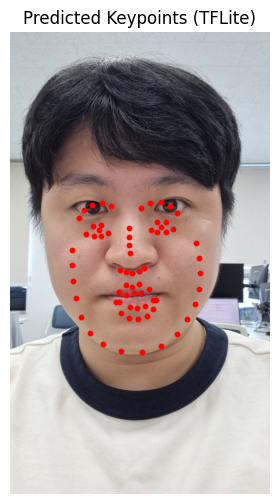

In [5]:
plot_predicted_keypoints_tflite(tflite_model_path, 'test.jpg', 'temp')